In [1]:
import torch 
from torch import Tensor 
import numpy as np
import math
import matplotlib.pyplot as plt
import math

In [2]:
class Relu:
    def forward(self, x):   
        self.x = x.clone()
        return x.clamp(min=0)
    
    def backward(self, dz):
        output = self.x.clone()
        output[output > 0] = 1
        output[output < 0] = 0
#         print("forwarded x")
#         print(self.x[:5])
#         print("output")
#         print(output[:5])
#         print("dz come")
#         print(dz[:5])
#         print("backwarded update")
#         print(dz.mul(output).shape)
        return dz.mul(output)

In [3]:
class Tanh:
    
    def forward(self, x):
        self.x = x.clone()
        self.output = Tensor.tanh(x)
        return self.output;

    def backward(self, dz):
#         print("forwarded x")
#         print(self.x[:5])
#         print("output")
#         print(self.output[:5])
#         print("dz come")
#         print(dz[:5])
#         print("backwarded update")
#         print(dz.mul(1.0 - Tensor.tanh(self.x).pow(2))[:5])
        return dz.mul(1.0 - Tensor.tanh(self.x).pow(2))
        

In [4]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias xavie initializer
        stdv = 1. / math.sqrt(input_size)
        self.w = Tensor(hidden_nodes, input_size).uniform_(-stdv, stdv)
        self.b = Tensor(hidden_nodes).uniform_(-stdv, stdv) 
        self.dw = Tensor(self.w.size()).zero_()
        self.db = Tensor(self.b.size()).zero_()
#         self.db = Tensor(self.b.size()).normal_(-10,100)
#         self.dw = Tensor(self.w.size()).normal_(-10,100)
        
    def forward(self, x):
        self.x = x.clone()
        s = x.matmul(self.w.t()) + self.b
        return s
        
    def backward(self, dz):
        
        dx = dz.matmul(self.w)
        dw = self.x.t().matmul(dz)
        db = dz.t().sum(1)
        
        self.dw += dw
        self.db += db
        
        return dx
        
    def params(self):
        return (self.w, self.b, self.dw,self.db)
    
    
    def update_params(self, lambda_):
        self.w -= lambda_ * self.dw
        self.b -= lambda_ * self.db
        
    
    def zero_gradient(self):
        self.dw.zero_()
        self.db.zero_()

In [5]:
class LossMSE: 
        
    def forward(self, t, x):
        self.t = t.clone()
        self.x = x.clone()
        self.output = (self.x - self.t).pow(2).mean()

        return self.output
    
    def backward(self):
#         print("t")
#         print(self.t)
#         print("x")
#         print(self.x)
#         print("error")
#         print(self.output)
        dloss = 2 * (self.t - self.x)/self.x.shape[0]/2
#         print(self.x.shape)
        return dloss

In [6]:
class Sequential:
    
    def __init__(self, layer_modules):
        self.layer_modules = layer_modules

        
    def forward(self, x_input):
        module_input = x_input.clone()
        
        # hidden layer
        for i in range(len(self.layer_modules)): 
            module_output = self.layer_modules[i].forward(module_input)
            module_input = module_output
        return module_output
    
    def backward(self, dz):
        for i in range(len(self.layer_modules) - 1, -1, -1):
            dz = self.layer_modules[i].backward(dz) 
    
    def update_params(self, lambda_):
        for m in self.layer_modules:
            if isinstance(m, Linear): 
                m.update_params(lambda_);

    
    def zero_gradient(self):
        for m in self.layer_modules:
            if isinstance(m, Linear):
                m.zero_gradient()
    
    def get_params(self):
        for m in self.layer_modules:
            print('{},{}'.format(m.params()[0], m.params()[1]))


In [7]:
def train_model(model, train_input, train_target, test_input, test_target, nb_epochs, lr,mini_batch_size ):
    
    criterion = LossMSE()
    
    for m in range(nb_epochs):

        total_loss = 0    
        
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
#             print(output)
            total_loss  += criterion.forward(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_gradient()
            dloss = criterion.backward()
#             print("dloss")
#             print(dloss[:5])
            model.backward(dloss)
            model.update_params(lr)
        
        train_errors = compute_nb_errors(model, train_input, train_target)
        test_errors = compute_nb_errors(model, test_input, test_target)
        print("================================{}===================================".format(m))
        
        print(  '{}/{}: train_loss: {} train_error {:.02f}% test_error {:.02f}%'.format(m , nb_epochs,total_loss,
                train_errors/ train_input.size(0) * 100,
                test_errors / test_input.size(0) * 100))  

def compute_nb_errors(model, data_input, data_target):

    nb_data_errors = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(0, mini_batch_size):
            if data_target[b + k][predicted_classes[k]]  < 0:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

### Generate data

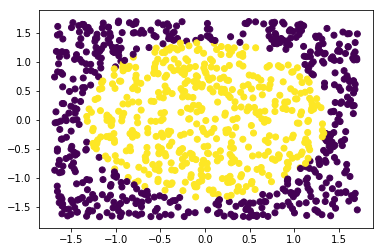

In [8]:
data = torch.FloatTensor(1000,2).uniform_(0, 1) - 0.5
distance = torch.sqrt(torch.pow(data[:, 0], 2) + torch.pow(data[:,1],2)).view(-1,1)
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 1 if x < radius else  -1)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  -1)

target = torch.cat((inside, outside),1)


data = (data - data.mean())/ data.std()
# plt.scatter(data[:,0], data[:,1], c=inside)
# plt.show()
plt.scatter(data[:,0], data[:,1], c=inside.squeeze())
plt.show()

## Train model

In [10]:
lr =  5e-4
mini_batch_size = 200
nb_epochs = 10000
# modules = [Linear(2, 25), Relu(),Linear(25, 25),Relu(),Linear(25, 25),Relu(),Linear(25, 2), Tanh()]
modules = [Linear(2, 25), Relu(), Linear(25,25), Relu(), Linear(25, 2), Tanh()]
model = Sequential(modules)

train_input, train_target, test_input, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]

train_model(model, train_input, train_target, test_input, test_target, nb_epochs, lr, mini_batch_size)


/home/cheng-chun-epfl/anaconda3/lib/python3.6/site-packages/torch/tensor.py:309: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)


================================0===================================
0/10000: train_loss: 4.112853581309318 train_error 46.88% test_error 51.00%
================================1===================================
1/10000: train_loss: 4.112475614473223 train_error 46.88% test_error 51.00%
================================2===================================
2/10000: train_loss: 4.112099702432752 train_error 46.88% test_error 51.00%
================================3===================================
3/10000: train_loss: 4.111725694164633 train_error 46.88% test_error 51.00%
================================4===================================
4/10000: train_loss: 4.111353584378957 train_error 46.88% test_error 51.00%
================================5===================================
5/10000: train_loss: 4.110983426421881 train_error 46.88% test_error 51.00%
================================6===================================
6/10000: train_loss: 4.110615198537707 train_error 46.88% tes

================================103===================================
103/10000: train_loss: 4.082713262960315 train_error 46.88% test_error 51.00%
================================104===================================
104/10000: train_loss: 4.082493897527456 train_error 46.88% test_error 51.00%
================================105===================================
105/10000: train_loss: 4.082275720089674 train_error 46.88% test_error 51.00%
================================106===================================
106/10000: train_loss: 4.0820586888492105 train_error 46.88% test_error 51.00%
================================107===================================
107/10000: train_loss: 4.081842848956585 train_error 46.88% test_error 51.00%
================================108===================================
108/10000: train_loss: 4.081628137081861 train_error 46.88% test_error 51.00%
================================109===================================
109/10000: train_loss: 4.081414559

================================207===================================
207/10000: train_loss: 4.06523753747344 train_error 46.88% test_error 51.00%
================================208===================================
208/10000: train_loss: 4.065113569945097 train_error 46.88% test_error 51.00%
================================209===================================
209/10000: train_loss: 4.064990279525519 train_error 46.88% test_error 51.00%
================================210===================================
210/10000: train_loss: 4.0648677167296405 train_error 46.88% test_error 51.00%
================================211===================================
211/10000: train_loss: 4.064745826870203 train_error 46.88% test_error 51.00%
================================212===================================
212/10000: train_loss: 4.064624583274126 train_error 46.88% test_error 51.00%
================================213===================================
213/10000: train_loss: 4.0645040261

================================264===================================
264/10000: train_loss: 4.059171454310417 train_error 46.88% test_error 51.00%
================================265===================================
265/10000: train_loss: 4.059081539511681 train_error 46.88% test_error 51.00%
================================266===================================
266/10000: train_loss: 4.058992156386375 train_error 46.88% test_error 51.00%
================================267===================================
267/10000: train_loss: 4.058903311789035 train_error 46.88% test_error 51.00%
================================268===================================
268/10000: train_loss: 4.058814935833216 train_error 46.88% test_error 51.00%
================================269===================================
269/10000: train_loss: 4.058727111369371 train_error 46.88% test_error 51.00%
================================270===================================
270/10000: train_loss: 4.0586397734

================================321===================================
321/10000: train_loss: 4.054819932878017 train_error 46.88% test_error 51.00%
================================322===================================
322/10000: train_loss: 4.054756236225367 train_error 46.88% test_error 51.00%
================================323===================================
323/10000: train_loss: 4.054692936390638 train_error 46.88% test_error 51.00%
================================324===================================
324/10000: train_loss: 4.054630020409822 train_error 46.88% test_error 51.00%
================================325===================================
325/10000: train_loss: 4.054567504376173 train_error 46.88% test_error 51.00%
================================326===================================
326/10000: train_loss: 4.0545053726434706 train_error 46.88% test_error 51.00%
================================327===================================
327/10000: train_loss: 4.054443633

================================432===================================
432/10000: train_loss: 4.049762597233057 train_error 46.88% test_error 51.00%
================================433===================================
433/10000: train_loss: 4.049732238352299 train_error 46.88% test_error 51.00%
================================434===================================
434/10000: train_loss: 4.049702101349831 train_error 46.88% test_error 51.00%
================================435===================================
435/10000: train_loss: 4.049672219902277 train_error 46.88% test_error 51.00%
================================436===================================
436/10000: train_loss: 4.0496425610780715 train_error 46.88% test_error 51.00%
================================437===================================
437/10000: train_loss: 4.049613111317158 train_error 46.88% test_error 51.00%
================================438===================================
438/10000: train_loss: 4.049583891

================================489===================================
489/10000: train_loss: 4.048368306457997 train_error 46.88% test_error 51.00%
================================490===================================
490/10000: train_loss: 4.048349299728871 train_error 46.88% test_error 51.00%
================================491===================================
491/10000: train_loss: 4.048330408185721 train_error 46.88% test_error 51.00%
================================492===================================
492/10000: train_loss: 4.048311676681042 train_error 46.88% test_error 51.00%
================================493===================================
493/10000: train_loss: 4.048293114602566 train_error 46.88% test_error 51.00%
================================494===================================
494/10000: train_loss: 4.048274713605642 train_error 46.88% test_error 51.00%
================================495===================================
495/10000: train_loss: 4.0482565246

================================544===================================
544/10000: train_loss: 4.047563292831183 train_error 47.00% test_error 51.00%
================================545===================================
545/10000: train_loss: 4.047552652359009 train_error 47.00% test_error 51.00%
================================546===================================
546/10000: train_loss: 4.04754217132926 train_error 47.00% test_error 51.00%
================================547===================================
547/10000: train_loss: 4.047531894743443 train_error 47.00% test_error 51.00%
================================548===================================
548/10000: train_loss: 4.047521732747555 train_error 47.00% test_error 51.00%
================================549===================================
549/10000: train_loss: 4.047511704862117 train_error 47.00% test_error 51.00%
================================550===================================
550/10000: train_loss: 4.04750178858

================================655===================================
655/10000: train_loss: 4.047081264257431 train_error 47.25% test_error 51.00%
================================656===================================
656/10000: train_loss: 4.047082354277372 train_error 47.25% test_error 51.00%
================================657===================================
657/10000: train_loss: 4.047083503007888 train_error 47.25% test_error 51.00%
================================658===================================
658/10000: train_loss: 4.04708474457264 train_error 47.25% test_error 51.00%
================================659===================================
659/10000: train_loss: 4.047086026519537 train_error 47.25% test_error 51.00%
================================660===================================
660/10000: train_loss: 4.047087395638227 train_error 47.25% test_error 51.00%
================================661===================================
661/10000: train_loss: 4.04708885639

================================713===================================
713/10000: train_loss: 4.047264680564403 train_error 47.38% test_error 51.00%
================================714===================================
714/10000: train_loss: 4.047269877046347 train_error 47.38% test_error 51.00%
================================715===================================
715/10000: train_loss: 4.047275127917528 train_error 47.38% test_error 51.00%
================================716===================================
716/10000: train_loss: 4.047280435711145 train_error 47.38% test_error 51.00%
================================717===================================
717/10000: train_loss: 4.047285742163658 train_error 47.38% test_error 51.00%
================================718===================================
718/10000: train_loss: 4.047291123718024 train_error 47.38% test_error 51.00%
================================719===================================
719/10000: train_loss: 4.0472965596

================================769===================================
769/10000: train_loss: 4.047634604424238 train_error 47.50% test_error 51.00%
================================770===================================
770/10000: train_loss: 4.0476424738764765 train_error 47.50% test_error 51.00%
================================771===================================
771/10000: train_loss: 4.047650378644467 train_error 47.50% test_error 51.00%
================================772===================================
772/10000: train_loss: 4.047658340632916 train_error 47.50% test_error 51.00%
================================773===================================
773/10000: train_loss: 4.047666362226009 train_error 47.50% test_error 51.00%
================================774===================================
774/10000: train_loss: 4.047674412578344 train_error 47.50% test_error 51.00%
================================775===================================
775/10000: train_loss: 4.047682532

================================825===================================
825/10000: train_loss: 4.04814218133688 train_error 47.50% test_error 51.50%
================================826===================================
826/10000: train_loss: 4.0481523881852635 train_error 47.50% test_error 51.50%
================================827===================================
827/10000: train_loss: 4.048162631541491 train_error 47.50% test_error 51.50%
================================828===================================
828/10000: train_loss: 4.048172951936722 train_error 47.50% test_error 51.50%
================================829===================================
829/10000: train_loss: 4.048183352053165 train_error 47.50% test_error 51.50%
================================830===================================
830/10000: train_loss: 4.048193805813789 train_error 47.50% test_error 51.50%
================================831===================================
831/10000: train_loss: 4.0482043859

================================881===================================
881/10000: train_loss: 4.048774582892657 train_error 47.62% test_error 52.00%
================================882===================================
882/10000: train_loss: 4.048786772489548 train_error 47.62% test_error 52.00%
================================883===================================
883/10000: train_loss: 4.048798959553242 train_error 47.62% test_error 52.00%
================================884===================================
884/10000: train_loss: 4.04881115347147 train_error 47.62% test_error 52.00%
================================885===================================
885/10000: train_loss: 4.048823368400335 train_error 47.62% test_error 52.00%
================================886===================================
886/10000: train_loss: 4.0488356140255926 train_error 47.62% test_error 52.00%
================================887===================================
887/10000: train_loss: 4.0488478942

================================937===================================
937/10000: train_loss: 4.049486383497715 train_error 48.25% test_error 53.00%
================================938===================================
938/10000: train_loss: 4.049499661326408 train_error 48.25% test_error 53.00%
================================939===================================
939/10000: train_loss: 4.049512949883939 train_error 48.25% test_error 53.00%
================================940===================================
940/10000: train_loss: 4.049526258558035 train_error 48.25% test_error 53.00%
================================941===================================
941/10000: train_loss: 4.049539588242769 train_error 48.25% test_error 53.00%
================================942===================================
942/10000: train_loss: 4.04955294162035 train_error 48.25% test_error 53.00%
================================943===================================
943/10000: train_loss: 4.04956633970

================================993===================================
993/10000: train_loss: 4.050258317887783 train_error 48.50% test_error 53.00%
================================994===================================
994/10000: train_loss: 4.050272184461355 train_error 48.50% test_error 53.00%
================================995===================================
995/10000: train_loss: 4.050286077260971 train_error 48.50% test_error 53.00%
================================996===================================
996/10000: train_loss: 4.050299960821867 train_error 48.50% test_error 53.00%
================================997===================================
997/10000: train_loss: 4.050313881784677 train_error 48.62% test_error 53.00%
================================998===================================
998/10000: train_loss: 4.050327800065279 train_error 48.62% test_error 53.00%
================================999===================================
999/10000: train_loss: 4.0503417454

================================1100===================================
1100/10000: train_loss: 4.05177499473095 train_error 49.25% test_error 54.00%
================================1101===================================
1101/10000: train_loss: 4.051789201796055 train_error 49.25% test_error 54.00%
================================1102===================================
1102/10000: train_loss: 4.051803387701511 train_error 49.25% test_error 54.00%
================================1103===================================
1103/10000: train_loss: 4.0518174861371525 train_error 49.25% test_error 54.00%
================================1104===================================
1104/10000: train_loss: 4.051831587702036 train_error 49.25% test_error 54.00%
================================1105===================================
1105/10000: train_loss: 4.05184567540884 train_error 49.25% test_error 54.00%
================================1106===================================
1106/10000: train_loss:

================================1155===================================
1155/10000: train_loss: 4.052559558600187 train_error 49.25% test_error 54.00%
================================1156===================================
1156/10000: train_loss: 4.052573979198933 train_error 49.25% test_error 54.00%
================================1157===================================
1157/10000: train_loss: 4.0525883954763415 train_error 49.38% test_error 54.00%
================================1158===================================
1158/10000: train_loss: 4.052602830827237 train_error 49.38% test_error 54.00%
================================1159===================================
1159/10000: train_loss: 4.052617306113243 train_error 49.38% test_error 54.00%
================================1160===================================
1160/10000: train_loss: 4.052631827443838 train_error 49.38% test_error 54.00%
================================1161===================================
1161/10000: train_los

================================1212===================================
1212/10000: train_loss: 4.0533900314569475 train_error 49.75% test_error 54.00%
================================1213===================================
1213/10000: train_loss: 4.053404550105333 train_error 49.75% test_error 54.00%
================================1214===================================
1214/10000: train_loss: 4.053419072628021 train_error 49.75% test_error 54.00%
================================1215===================================
1215/10000: train_loss: 4.053433608561754 train_error 49.75% test_error 54.00%
================================1216===================================
1216/10000: train_loss: 4.053448133468628 train_error 49.75% test_error 54.00%
================================1217===================================
1217/10000: train_loss: 4.053462669700385 train_error 49.75% test_error 54.00%
================================1218===================================
1218/10000: train_los

================================1267===================================
1267/10000: train_loss: 4.054179957807063 train_error 49.88% test_error 54.50%
================================1268===================================
1268/10000: train_loss: 4.054194088727236 train_error 49.88% test_error 54.50%
================================1269===================================
1269/10000: train_loss: 4.054208203107119 train_error 49.88% test_error 54.50%
================================1270===================================
1270/10000: train_loss: 4.054222222864627 train_error 49.88% test_error 54.50%
================================1271===================================
1271/10000: train_loss: 4.054236204326153 train_error 49.88% test_error 54.50%
================================1272===================================
1272/10000: train_loss: 4.0542501944303515 train_error 49.88% test_error 54.50%
================================1273===================================
1273/10000: train_los

================================1324===================================
1324/10000: train_loss: 4.054980184584856 train_error 50.25% test_error 55.00%
================================1325===================================
1325/10000: train_loss: 4.0549940603971475 train_error 50.25% test_error 55.00%
================================1326===================================
1326/10000: train_loss: 4.0550079329311846 train_error 50.25% test_error 55.00%
================================1327===================================
1327/10000: train_loss: 4.055021780580283 train_error 50.25% test_error 55.00%
================================1328===================================
1328/10000: train_loss: 4.055035499483347 train_error 50.25% test_error 55.00%
================================1329===================================
1329/10000: train_loss: 4.055049219280481 train_error 50.25% test_error 55.00%
================================1330===================================
1330/10000: train_lo

================================1430===================================
1430/10000: train_loss: 4.056395337283612 train_error 51.00% test_error 55.50%
================================1431===================================
1431/10000: train_loss: 4.056408152282238 train_error 51.00% test_error 55.50%
================================1432===================================
1432/10000: train_loss: 4.056420929282904 train_error 51.00% test_error 55.50%
================================1433===================================
1433/10000: train_loss: 4.056433717161417 train_error 51.00% test_error 55.50%
================================1434===================================
1434/10000: train_loss: 4.056446532011032 train_error 51.00% test_error 55.50%
================================1435===================================
1435/10000: train_loss: 4.056459347754717 train_error 51.00% test_error 55.50%
================================1436===================================
1436/10000: train_loss

================================1487===================================
1487/10000: train_loss: 4.057085050344467 train_error 51.75% test_error 55.50%
================================1488===================================
1488/10000: train_loss: 4.057096216082573 train_error 51.75% test_error 55.50%
================================1489===================================
1489/10000: train_loss: 4.057107406109571 train_error 51.75% test_error 55.50%
================================1490===================================
1490/10000: train_loss: 4.057118627578021 train_error 51.75% test_error 55.50%
================================1491===================================
1491/10000: train_loss: 4.057129607200623 train_error 51.75% test_error 55.50%
================================1492===================================
1492/10000: train_loss: 4.057140559852123 train_error 51.75% test_error 55.50%
================================1493===================================
1493/10000: train_loss

================================1543===================================
1543/10000: train_loss: 4.0576484276354305 train_error 52.00% test_error 56.00%
================================1544===================================
1544/10000: train_loss: 4.057657391726971 train_error 52.00% test_error 56.00%
================================1545===================================
1545/10000: train_loss: 4.057666278332472 train_error 52.00% test_error 56.00%
================================1546===================================
1546/10000: train_loss: 4.057675142586231 train_error 52.00% test_error 56.00%
================================1547===================================
1547/10000: train_loss: 4.0576839615404605 train_error 52.00% test_error 56.00%
================================1548===================================
1548/10000: train_loss: 4.0576926258206365 train_error 52.00% test_error 56.00%
================================1549===================================
1549/10000: train_l

================================1602===================================
1602/10000: train_loss: 4.058111416399479 train_error 52.25% test_error 57.00%
================================1603===================================
1603/10000: train_loss: 4.058118162602186 train_error 52.25% test_error 57.00%
================================1604===================================
1604/10000: train_loss: 4.058124991208315 train_error 52.25% test_error 57.00%
================================1605===================================
1605/10000: train_loss: 4.058131907582283 train_error 52.25% test_error 57.00%
================================1606===================================
1606/10000: train_loss: 4.058138802945614 train_error 52.25% test_error 57.00%
================================1607===================================
1607/10000: train_loss: 4.05814569413662 train_error 52.25% test_error 57.00%
================================1608===================================
1608/10000: train_loss:

================================1659===================================
1659/10000: train_loss: 4.058405462950468 train_error 52.38% test_error 57.00%
================================1660===================================
1660/10000: train_loss: 4.05840903967619 train_error 52.38% test_error 57.00%
================================1661===================================
1661/10000: train_loss: 4.058412617146969 train_error 52.38% test_error 57.00%
================================1662===================================
1662/10000: train_loss: 4.058416154384613 train_error 52.38% test_error 57.00%
================================1663===================================
1663/10000: train_loss: 4.058419820815325 train_error 52.38% test_error 57.00%
================================1664===================================
1664/10000: train_loss: 4.058423587828875 train_error 52.38% test_error 57.00%
================================1665===================================
1665/10000: train_loss:

================================1715===================================
1715/10000: train_loss: 4.058527907133102 train_error 52.62% test_error 57.50%
================================1716===================================
1716/10000: train_loss: 4.0585284362733365 train_error 52.75% test_error 57.50%
================================1717===================================
1717/10000: train_loss: 4.058528962135314 train_error 52.75% test_error 57.50%
================================1718===================================
1718/10000: train_loss: 4.058529336601496 train_error 52.75% test_error 57.50%
================================1719===================================
1719/10000: train_loss: 4.058529544174672 train_error 52.75% test_error 57.50%
================================1720===================================
1720/10000: train_loss: 4.058529728949069 train_error 52.75% test_error 57.50%
================================1721===================================
1721/10000: train_los

================================1773===================================
1773/10000: train_loss: 4.058445116430521 train_error 52.88% test_error 57.50%
================================1774===================================
1774/10000: train_loss: 4.058441653102636 train_error 52.88% test_error 57.50%
================================1775===================================
1775/10000: train_loss: 4.058438113480807 train_error 52.88% test_error 57.50%
================================1776===================================
1776/10000: train_loss: 4.05843456864357 train_error 52.88% test_error 57.50%
================================1777===================================
1777/10000: train_loss: 4.058430804163217 train_error 52.88% test_error 57.50%
================================1778===================================
1778/10000: train_loss: 4.058426896035671 train_error 52.88% test_error 57.50%
================================1779===================================
1779/10000: train_loss:

================================1878===================================
1878/10000: train_loss: 4.057566983401776 train_error 53.75% test_error 58.50%
================================1879===================================
1879/10000: train_loss: 4.0575539898872375 train_error 53.75% test_error 58.50%
================================1880===================================
1880/10000: train_loss: 4.057541274875402 train_error 53.75% test_error 58.50%
================================1881===================================
1881/10000: train_loss: 4.057528578788043 train_error 53.75% test_error 58.50%
================================1882===================================
1882/10000: train_loss: 4.057515864372253 train_error 53.75% test_error 58.50%
================================1883===================================
1883/10000: train_loss: 4.0575032204389565 train_error 53.75% test_error 58.50%
================================1884===================================
1884/10000: train_lo

================================1933===================================
1933/10000: train_loss: 4.056780732870102 train_error 53.75% test_error 58.50%
================================1934===================================
1934/10000: train_loss: 4.056764483302832 train_error 53.75% test_error 58.50%
================================1935===================================
1935/10000: train_loss: 4.05674815967679 train_error 53.75% test_error 58.50%
================================1936===================================
1936/10000: train_loss: 4.056731479614973 train_error 53.62% test_error 58.50%
================================1937===================================
1937/10000: train_loss: 4.056714764982463 train_error 53.62% test_error 58.50%
================================1938===================================
1938/10000: train_loss: 4.056698016822338 train_error 53.62% test_error 58.50%
================================1939===================================
1939/10000: train_loss:

================================2043===================================
2043/10000: train_loss: 4.0544043250381945 train_error 53.87% test_error 60.00%
================================2044===================================
2044/10000: train_loss: 4.054377529621124 train_error 53.87% test_error 60.00%
================================2045===================================
2045/10000: train_loss: 4.054350678920747 train_error 53.87% test_error 60.00%
================================2046===================================
2046/10000: train_loss: 4.054323791265488 train_error 53.87% test_error 60.00%
================================2047===================================
2047/10000: train_loss: 4.054296756833792 train_error 53.87% test_error 60.00%
================================2048===================================
2048/10000: train_loss: 4.0542696146667 train_error 53.87% test_error 60.00%
================================2049===================================
2049/10000: train_loss:

================================2100===================================
2100/10000: train_loss: 4.052773839086294 train_error 54.00% test_error 61.00%
================================2101===================================
2101/10000: train_loss: 4.052742693871259 train_error 54.00% test_error 61.00%
================================2102===================================
2102/10000: train_loss: 4.052711504250764 train_error 54.00% test_error 61.00%
================================2103===================================
2103/10000: train_loss: 4.052680280804634 train_error 54.00% test_error 61.00%
================================2104===================================
2104/10000: train_loss: 4.052649082541466 train_error 54.00% test_error 61.00%
================================2105===================================
2105/10000: train_loss: 4.052617888748646 train_error 54.00% test_error 61.00%
================================2106===================================
2106/10000: train_loss

================================2203===================================
2203/10000: train_loss: 4.049123232960701 train_error 54.12% test_error 60.00%
================================2204===================================
2204/10000: train_loss: 4.049083035290241 train_error 54.12% test_error 60.00%
================================2205===================================
2205/10000: train_loss: 4.0490427400171765 train_error 54.25% test_error 60.00%
================================2206===================================
2206/10000: train_loss: 4.049002312272787 train_error 54.25% test_error 60.00%
================================2207===================================
2207/10000: train_loss: 4.048961904495955 train_error 54.25% test_error 60.00%
================================2208===================================
2208/10000: train_loss: 4.048921375423669 train_error 54.25% test_error 60.00%
================================2209===================================
2209/10000: train_los

================================2299===================================
2299/10000: train_loss: 4.0450651970505715 train_error 54.87% test_error 60.00%
================================2300===================================
2300/10000: train_loss: 4.04502183496952 train_error 54.87% test_error 60.00%
================================2301===================================
2301/10000: train_loss: 4.044978396594525 train_error 54.87% test_error 60.00%
================================2302===================================
2302/10000: train_loss: 4.044935034960508 train_error 54.87% test_error 60.00%
================================2303===================================
2303/10000: train_loss: 4.044891605079174 train_error 54.87% test_error 60.00%
================================2304===================================
2304/10000: train_loss: 4.044848049283027 train_error 55.00% test_error 60.00%
================================2305===================================
2305/10000: train_loss

================================2354===================================
2354/10000: train_loss: 4.042643165141344 train_error 55.12% test_error 60.00%
================================2355===================================
2355/10000: train_loss: 4.042598205059766 train_error 55.12% test_error 60.00%
================================2356===================================
2356/10000: train_loss: 4.042553234100342 train_error 55.12% test_error 60.00%
================================2357===================================
2357/10000: train_loss: 4.042508211880922 train_error 55.12% test_error 60.00%
================================2358===================================
2358/10000: train_loss: 4.042463043779135 train_error 55.12% test_error 60.00%
================================2359===================================
2359/10000: train_loss: 4.0424177564680575 train_error 55.12% test_error 60.00%
================================2360===================================
2360/10000: train_los

================================2412===================================
2412/10000: train_loss: 4.039951688200235 train_error 55.50% test_error 61.00%
================================2413===================================
2413/10000: train_loss: 4.039903453886509 train_error 55.50% test_error 61.00%
================================2414===================================
2414/10000: train_loss: 4.03985531270504 train_error 55.50% test_error 61.00%
================================2415===================================
2415/10000: train_loss: 4.039807137399912 train_error 55.50% test_error 61.00%
================================2416===================================
2416/10000: train_loss: 4.039758925139904 train_error 55.50% test_error 60.50%
================================2417===================================
2417/10000: train_loss: 4.0397106164693835 train_error 55.62% test_error 60.50%
================================2418===================================
2418/10000: train_loss

================================2468===================================
2468/10000: train_loss: 4.037170994281769 train_error 55.75% test_error 59.50%
================================2469===================================
2469/10000: train_loss: 4.037120702415704 train_error 55.75% test_error 59.50%
================================2470===================================
2470/10000: train_loss: 4.037070781737566 train_error 55.62% test_error 59.50%
================================2471===================================
2471/10000: train_loss: 4.037021131813526 train_error 55.62% test_error 59.50%
================================2472===================================
2472/10000: train_loss: 4.036971709430218 train_error 55.62% test_error 59.50%
================================2473===================================
2473/10000: train_loss: 4.036922266483307 train_error 55.62% test_error 59.50%
================================2474===================================
2474/10000: train_loss

================================2572===================================
2572/10000: train_loss: 4.031894038468599 train_error 55.00% test_error 60.00%
================================2573===================================
2573/10000: train_loss: 4.031842506229877 train_error 55.00% test_error 60.00%
================================2574===================================
2574/10000: train_loss: 4.031790754497051 train_error 55.00% test_error 60.00%
================================2575===================================
2575/10000: train_loss: 4.031739058196544 train_error 55.00% test_error 60.00%
================================2576===================================
2576/10000: train_loss: 4.031687328368426 train_error 54.87% test_error 60.00%
================================2577===================================
2577/10000: train_loss: 4.031635663360357 train_error 54.87% test_error 60.00%
================================2578===================================
2578/10000: train_loss

================================2674===================================
2674/10000: train_loss: 4.026343606114388 train_error 54.37% test_error 60.00%
================================2675===================================
2675/10000: train_loss: 4.026284490972757 train_error 54.37% test_error 60.00%
================================2676===================================
2676/10000: train_loss: 4.026225063949823 train_error 54.37% test_error 60.00%
================================2677===================================
2677/10000: train_loss: 4.0261654825508595 train_error 54.37% test_error 60.00%
================================2678===================================
2678/10000: train_loss: 4.026105773448944 train_error 54.37% test_error 60.00%
================================2679===================================
2679/10000: train_loss: 4.026046027690172 train_error 54.37% test_error 60.00%
================================2680===================================
2680/10000: train_los

================================2770===================================
2770/10000: train_loss: 4.020326878428459 train_error 54.37% test_error 58.50%
================================2771===================================
2771/10000: train_loss: 4.020261155217886 train_error 54.37% test_error 58.50%
================================2772===================================
2772/10000: train_loss: 4.020195373147726 train_error 54.50% test_error 58.50%
================================2773===================================
2773/10000: train_loss: 4.020129548311234 train_error 54.50% test_error 58.50%
================================2774===================================
2774/10000: train_loss: 4.020063620656729 train_error 54.50% test_error 58.50%
================================2775===================================
2775/10000: train_loss: 4.019997443854809 train_error 54.50% test_error 58.50%
================================2776===================================
2776/10000: train_loss

================================2870===================================
2870/10000: train_loss: 4.013248735070229 train_error 54.50% test_error 58.00%
================================2871===================================
2871/10000: train_loss: 4.013172663003206 train_error 54.50% test_error 58.00%
================================2872===================================
2872/10000: train_loss: 4.013096551895142 train_error 54.50% test_error 58.00%
================================2873===================================
2873/10000: train_loss: 4.013020399063826 train_error 54.50% test_error 58.00%
================================2874===================================
2874/10000: train_loss: 4.012944474071264 train_error 54.50% test_error 58.00%
================================2875===================================
2875/10000: train_loss: 4.012868721336126 train_error 54.50% test_error 58.00%
================================2876===================================
2876/10000: train_loss

================================2976===================================
2976/10000: train_loss: 4.004691156446934 train_error 54.75% test_error 58.00%
================================2977===================================
2977/10000: train_loss: 4.0046055978536605 train_error 54.75% test_error 58.00%
================================2978===================================
2978/10000: train_loss: 4.004519877433777 train_error 54.75% test_error 58.00%
================================2979===================================
2979/10000: train_loss: 4.004433763176203 train_error 54.75% test_error 58.00%
================================2980===================================
2980/10000: train_loss: 4.0043476934731 train_error 54.75% test_error 58.00%
================================2981===================================
2981/10000: train_loss: 4.004261500388385 train_error 54.75% test_error 58.00%
================================2982===================================
2982/10000: train_loss:

================================3074===================================
3074/10000: train_loss: 3.995438433736563 train_error 54.37% test_error 58.00%
================================3075===================================
3075/10000: train_loss: 3.9953347887098793 train_error 54.37% test_error 58.00%
================================3076===================================
3076/10000: train_loss: 3.9952311284840105 train_error 54.37% test_error 58.00%
================================3077===================================
3077/10000: train_loss: 3.9951273854076863 train_error 54.37% test_error 58.00%
================================3078===================================
3078/10000: train_loss: 3.995023457556963 train_error 54.37% test_error 58.00%
================================3079===================================
3079/10000: train_loss: 3.9949196116626258 train_error 54.50% test_error 58.00%
================================3080===================================
3080/10000: train_

================================3180===================================
3180/10000: train_loss: 3.983492469340563 train_error 54.12% test_error 57.50%
================================3181===================================
3181/10000: train_loss: 3.9833665309846404 train_error 54.12% test_error 57.50%
================================3182===================================
3182/10000: train_loss: 3.9832403998076917 train_error 54.12% test_error 57.50%
================================3183===================================
3183/10000: train_loss: 3.9831140215694907 train_error 54.12% test_error 57.00%
================================3184===================================
3184/10000: train_loss: 3.982987725585699 train_error 54.12% test_error 57.00%
================================3185===================================
3185/10000: train_loss: 3.982861271202564 train_error 54.00% test_error 57.00%
================================3186===================================
3186/10000: train_l

================================3288===================================
3288/10000: train_loss: 3.968935418725014 train_error 53.12% test_error 57.00%
================================3289===================================
3289/10000: train_loss: 3.96879034742713 train_error 53.12% test_error 57.00%
================================3290===================================
3290/10000: train_loss: 3.9686446774005892 train_error 53.12% test_error 56.50%
================================3291===================================
3291/10000: train_loss: 3.968498955070973 train_error 53.12% test_error 56.50%
================================3292===================================
3292/10000: train_loss: 3.968353093415499 train_error 53.12% test_error 56.50%
================================3293===================================
3293/10000: train_loss: 3.968206778615713 train_error 53.12% test_error 56.50%
================================3294===================================
3294/10000: train_loss

================================3345===================================
3345/10000: train_loss: 3.9605424432456493 train_error 52.88% test_error 56.00%
================================3346===================================
3346/10000: train_loss: 3.9603907534480096 train_error 52.88% test_error 56.00%
================================3347===================================
3347/10000: train_loss: 3.9602389247715477 train_error 52.75% test_error 56.00%
================================3348===================================
3348/10000: train_loss: 3.9600872491300105 train_error 52.75% test_error 56.00%
================================3349===================================
3349/10000: train_loss: 3.9599353991448876 train_error 52.75% test_error 56.00%
================================3350===================================
3350/10000: train_loss: 3.9597836515307425 train_error 52.75% test_error 56.00%
================================3351===================================
3351/10000: trai

================================3402===================================
3402/10000: train_loss: 3.951892033070326 train_error 52.00% test_error 56.00%
================================3403===================================
3403/10000: train_loss: 3.951739526540041 train_error 52.00% test_error 56.00%
================================3404===================================
3404/10000: train_loss: 3.9515868920087813 train_error 52.00% test_error 56.00%
================================3405===================================
3405/10000: train_loss: 3.951434487998485 train_error 52.00% test_error 56.00%
================================3406===================================
3406/10000: train_loss: 3.95128197863698 train_error 52.00% test_error 56.00%
================================3407===================================
3407/10000: train_loss: 3.951129055917263 train_error 52.00% test_error 56.00%
================================3408===================================
3408/10000: train_loss

================================3459===================================
3459/10000: train_loss: 3.9431043576449163 train_error 51.62% test_error 56.00%
================================3460===================================
3460/10000: train_loss: 3.9429510322958228 train_error 51.62% test_error 56.00%
================================3461===================================
3461/10000: train_loss: 3.9427976434677836 train_error 51.62% test_error 56.00%
================================3462===================================
3462/10000: train_loss: 3.9426440985500815 train_error 51.50% test_error 56.00%
================================3463===================================
3463/10000: train_loss: 3.942490365058184 train_error 51.50% test_error 56.00%
================================3464===================================
3464/10000: train_loss: 3.9423371109366414 train_error 51.50% test_error 56.00%
================================3465===================================
3465/10000: train

================================3568===================================
3568/10000: train_loss: 3.926089512780308 train_error 51.62% test_error 56.50%
================================3569===================================
3569/10000: train_loss: 3.925926704108715 train_error 51.62% test_error 56.50%
================================3570===================================
3570/10000: train_loss: 3.9257637320458887 train_error 51.62% test_error 56.00%
================================3571===================================
3571/10000: train_loss: 3.925600576028228 train_error 51.62% test_error 56.00%
================================3572===================================
3572/10000: train_loss: 3.9254372838139533 train_error 51.62% test_error 56.00%
================================3573===================================
3573/10000: train_loss: 3.9252738846838477 train_error 51.62% test_error 56.00%
================================3574===================================
3574/10000: train_l

================================3673===================================
3673/10000: train_loss: 3.908378769978881 train_error 50.88% test_error 54.00%
================================3674===================================
3674/10000: train_loss: 3.9082065636664627 train_error 50.88% test_error 54.00%
================================3675===================================
3675/10000: train_loss: 3.9080342496931553 train_error 51.00% test_error 54.00%
================================3676===================================
3676/10000: train_loss: 3.9078618558496236 train_error 51.00% test_error 54.00%
================================3677===================================
3677/10000: train_loss: 3.9076900555938483 train_error 50.88% test_error 54.00%
================================3678===================================
3678/10000: train_loss: 3.907517850995064 train_error 50.88% test_error 54.00%
================================3679===================================
3679/10000: train_

================================3780===================================
3780/10000: train_loss: 3.8895570838451383 train_error 49.50% test_error 53.00%
================================3781===================================
3781/10000: train_loss: 3.889372984543443 train_error 49.50% test_error 53.00%
================================3782===================================
3782/10000: train_loss: 3.889188773408532 train_error 49.50% test_error 53.00%
================================3783===================================
3783/10000: train_loss: 3.889004504531622 train_error 49.50% test_error 53.00%
================================3784===================================
3784/10000: train_loss: 3.8888201685994863 train_error 49.50% test_error 53.00%
================================3785===================================
3785/10000: train_loss: 3.8886357416957615 train_error 49.50% test_error 53.00%
================================3786===================================
3786/10000: train_l

================================3890===================================
3890/10000: train_loss: 3.868710970133543 train_error 48.62% test_error 51.50%
================================3891===================================
3891/10000: train_loss: 3.8685225013643505 train_error 48.62% test_error 51.50%
================================3892===================================
3892/10000: train_loss: 3.868331689015031 train_error 48.50% test_error 51.50%
================================3893===================================
3893/10000: train_loss: 3.8681400971859694 train_error 48.50% test_error 51.50%
================================3894===================================
3894/10000: train_loss: 3.867948410511017 train_error 48.50% test_error 51.50%
================================3895===================================
3895/10000: train_loss: 3.867756599262357 train_error 48.50% test_error 51.50%
================================3896===================================
3896/10000: train_lo

================================3948===================================
3948/10000: train_loss: 3.8577558769285676 train_error 48.38% test_error 51.50%
================================3949===================================
3949/10000: train_loss: 3.8575709020346403 train_error 48.38% test_error 51.50%
================================3950===================================
3950/10000: train_loss: 3.8573860083520413 train_error 48.38% test_error 51.50%
================================3951===================================
3951/10000: train_loss: 3.857201025933027 train_error 48.38% test_error 51.50%
================================3952===================================
3952/10000: train_loss: 3.8570158955454827 train_error 48.38% test_error 51.50%
================================3953===================================
3953/10000: train_loss: 3.856830662190914 train_error 48.38% test_error 51.50%
================================3954===================================
3954/10000: train_

================================4053===================================
4053/10000: train_loss: 3.8383077396452423 train_error 47.75% test_error 49.50%
================================4054===================================
4054/10000: train_loss: 3.8381223096698522 train_error 47.75% test_error 49.50%
================================4055===================================
4055/10000: train_loss: 3.8379365880042315 train_error 47.88% test_error 49.50%
================================4056===================================
4056/10000: train_loss: 3.8377516476809976 train_error 47.88% test_error 49.50%
================================4057===================================
4057/10000: train_loss: 3.8375666164606805 train_error 47.88% test_error 49.50%
================================4058===================================
4058/10000: train_loss: 3.8373815555870534 train_error 47.88% test_error 49.50%
================================4059===================================
4059/10000: trai

================================4161===================================
4161/10000: train_loss: 3.8187408792972564 train_error 47.12% test_error 48.00%
================================4162===================================
4162/10000: train_loss: 3.8185644379258155 train_error 47.12% test_error 48.00%
================================4163===================================
4163/10000: train_loss: 3.8183887764066458 train_error 47.12% test_error 48.00%
================================4164===================================
4164/10000: train_loss: 3.818213554471731 train_error 47.12% test_error 48.00%
================================4165===================================
4165/10000: train_loss: 3.8180382314324377 train_error 47.12% test_error 48.00%
================================4166===================================
4166/10000: train_loss: 3.817862892150879 train_error 47.12% test_error 48.00%
================================4167===================================
4167/10000: train_

================================4218===================================
4218/10000: train_loss: 3.808849801272154 train_error 46.88% test_error 47.50%
================================4219===================================
4219/10000: train_loss: 3.808678622692823 train_error 46.88% test_error 47.50%
================================4220===================================
4220/10000: train_loss: 3.8085083083063367 train_error 46.75% test_error 47.50%
================================4221===================================
4221/10000: train_loss: 3.808337941989303 train_error 46.75% test_error 47.50%
================================4222===================================
4222/10000: train_loss: 3.808167550563812 train_error 46.75% test_error 47.50%
================================4223===================================
4223/10000: train_loss: 3.8079974476993086 train_error 46.75% test_error 47.50%
================================4224===================================
4224/10000: train_lo

================================4321===================================
4321/10000: train_loss: 3.792324458733201 train_error 46.50% test_error 47.00%
================================4322===================================
4322/10000: train_loss: 3.7921779498457906 train_error 46.50% test_error 47.00%
================================4323===================================
4323/10000: train_loss: 3.792031106799841 train_error 46.50% test_error 47.00%
================================4324===================================
4324/10000: train_loss: 3.7918843081593514 train_error 46.50% test_error 47.00%
================================4325===================================
4325/10000: train_loss: 3.791737441048026 train_error 46.50% test_error 47.00%
================================4326===================================
4326/10000: train_loss: 3.791590507850051 train_error 46.50% test_error 47.00%
================================4327===================================
4327/10000: train_lo

================================4393===================================
4393/10000: train_loss: 3.7819126918911934 train_error 45.88% test_error 45.50%
================================4394===================================
4394/10000: train_loss: 3.7817727445065974 train_error 45.88% test_error 45.50%
================================4395===================================
4395/10000: train_loss: 3.781632805392146 train_error 45.88% test_error 45.50%
================================4396===================================
4396/10000: train_loss: 3.7814930127561093 train_error 45.88% test_error 45.50%
================================4397===================================
4397/10000: train_loss: 3.781353101283312 train_error 45.88% test_error 45.50%
================================4398===================================
4398/10000: train_loss: 3.7812138375639917 train_error 45.88% test_error 45.50%
================================4399===================================
4399/10000: train_

================================4461===================================
4461/10000: train_loss: 3.772890582233668 train_error 45.38% test_error 45.00%
================================4462===================================
4462/10000: train_loss: 3.7727651466429233 train_error 45.25% test_error 45.00%
================================4463===================================
4463/10000: train_loss: 3.772639657407999 train_error 45.38% test_error 45.00%
================================4464===================================
4464/10000: train_loss: 3.7725139842927455 train_error 45.38% test_error 45.00%
================================4465===================================
4465/10000: train_loss: 3.7723887185752396 train_error 45.38% test_error 45.00%
================================4466===================================
4466/10000: train_loss: 3.772263753041625 train_error 45.38% test_error 45.00%
================================4467===================================
4467/10000: train_l

================================4562===================================
4562/10000: train_loss: 3.760639751777053 train_error 45.62% test_error 44.00%
================================4563===================================
4563/10000: train_loss: 3.760522488579154 train_error 45.62% test_error 44.00%
================================4564===================================
4564/10000: train_loss: 3.7604052324593065 train_error 45.62% test_error 44.00%
================================4565===================================
4565/10000: train_loss: 3.76028800047934 train_error 45.62% test_error 44.00%
================================4566===================================
4566/10000: train_loss: 3.760170677825809 train_error 45.62% test_error 44.00%
================================4567===================================
4567/10000: train_loss: 3.7600532872974872 train_error 45.62% test_error 43.50%
================================4568===================================
4568/10000: train_los

================================4641===================================
4641/10000: train_loss: 3.751748173683882 train_error 45.12% test_error 43.00%
================================4642===================================
4642/10000: train_loss: 3.751634082198143 train_error 45.12% test_error 43.00%
================================4643===================================
4643/10000: train_loss: 3.7515202515572312 train_error 45.12% test_error 43.00%
================================4644===================================
4644/10000: train_loss: 3.751406833603978 train_error 45.12% test_error 43.00%
================================4645===================================
4645/10000: train_loss: 3.7512934600561856 train_error 45.12% test_error 43.00%
================================4646===================================
4646/10000: train_loss: 3.7511807080358266 train_error 45.12% test_error 43.00%
================================4647===================================
4647/10000: train_l

================================4697===================================
4697/10000: train_loss: 3.7454922810941937 train_error 45.12% test_error 42.50%
================================4698===================================
4698/10000: train_loss: 3.745381405130029 train_error 45.12% test_error 42.50%
================================4699===================================
4699/10000: train_loss: 3.7452714455872775 train_error 45.12% test_error 42.50%
================================4700===================================
4700/10000: train_loss: 3.745161444395781 train_error 45.12% test_error 42.50%
================================4701===================================
4701/10000: train_loss: 3.7450514709949494 train_error 45.12% test_error 42.50%
================================4702===================================
4702/10000: train_loss: 3.7449416579306125 train_error 45.12% test_error 42.50%
================================4703===================================
4703/10000: train_

================================4799===================================
4799/10000: train_loss: 3.7347415474802257 train_error 43.50% test_error 42.00%
================================4800===================================
4800/10000: train_loss: 3.7346383037418125 train_error 43.50% test_error 42.00%
================================4801===================================
4801/10000: train_loss: 3.734535033032298 train_error 43.38% test_error 42.00%
================================4802===================================
4802/10000: train_loss: 3.7344318481534717 train_error 43.38% test_error 42.00%
================================4803===================================
4803/10000: train_loss: 3.7343291064351796 train_error 43.38% test_error 42.00%
================================4804===================================
4804/10000: train_loss: 3.7342262333631515 train_error 43.38% test_error 42.00%
================================4805===================================
4805/10000: train

================================4902===================================
4902/10000: train_loss: 3.724293198660016 train_error 42.25% test_error 42.00%
================================4903===================================
4903/10000: train_loss: 3.7241934575140476 train_error 42.25% test_error 41.50%
================================4904===================================
4904/10000: train_loss: 3.724093416854739 train_error 42.25% test_error 41.50%
================================4905===================================
4905/10000: train_loss: 3.72399333037436 train_error 42.25% test_error 41.50%
================================4906===================================
4906/10000: train_loss: 3.723892963305116 train_error 42.25% test_error 41.50%
================================4907===================================
4907/10000: train_loss: 3.7237925995886325 train_error 42.25% test_error 41.50%
================================4908===================================
4908/10000: train_los

================================5002===================================
5002/10000: train_loss: 3.7143369092792273 train_error 41.62% test_error 41.00%
================================5003===================================
5003/10000: train_loss: 3.714235594719648 train_error 41.62% test_error 41.00%
================================5004===================================
5004/10000: train_loss: 3.7141349139809607 train_error 41.62% test_error 41.00%
================================5005===================================
5005/10000: train_loss: 3.714035342372954 train_error 41.50% test_error 41.00%
================================5006===================================
5006/10000: train_loss: 3.713936005793512 train_error 41.50% test_error 41.00%
================================5007===================================
5007/10000: train_loss: 3.71383690521121 train_error 41.50% test_error 41.00%
================================5008===================================
5008/10000: train_los

================================5106===================================
5106/10000: train_loss: 3.7039093390479687 train_error 40.50% test_error 39.00%
================================5107===================================
5107/10000: train_loss: 3.703799012117088 train_error 40.50% test_error 39.00%
================================5108===================================
5108/10000: train_loss: 3.703688555769622 train_error 40.50% test_error 39.00%
================================5109===================================
5109/10000: train_loss: 3.703577739335597 train_error 40.50% test_error 39.00%
================================5110===================================
5110/10000: train_loss: 3.703466566167772 train_error 40.50% test_error 39.00%
================================5111===================================
5111/10000: train_loss: 3.7033552327007055 train_error 40.50% test_error 39.00%
================================5112===================================
5112/10000: train_lo

================================5164===================================
5164/10000: train_loss: 3.697506203874946 train_error 40.50% test_error 39.00%
================================5165===================================
5165/10000: train_loss: 3.697397317476571 train_error 40.50% test_error 39.00%
================================5166===================================
5166/10000: train_loss: 3.697289082147181 train_error 40.50% test_error 39.00%
================================5167===================================
5167/10000: train_loss: 3.6971810986846685 train_error 40.50% test_error 39.00%
================================5168===================================
5168/10000: train_loss: 3.697072732411325 train_error 40.50% test_error 39.00%
================================5169===================================
5169/10000: train_loss: 3.696962996087968 train_error 40.50% test_error 39.00%
================================5170===================================
5170/10000: train_los

================================5272===================================
5272/10000: train_loss: 3.6854986972361807 train_error 40.00% test_error 38.50%
================================5273===================================
5273/10000: train_loss: 3.6853856558352707 train_error 40.00% test_error 38.50%
================================5274===================================
5274/10000: train_loss: 3.6852728194370865 train_error 40.00% test_error 38.50%
================================5275===================================
5275/10000: train_loss: 3.685160300284624 train_error 40.00% test_error 38.50%
================================5276===================================
5276/10000: train_loss: 3.68504776481539 train_error 40.00% test_error 38.50%
================================5277===================================
5277/10000: train_loss: 3.6849354746192695 train_error 40.00% test_error 38.50%
================================5278===================================
5278/10000: train_l

================================5331===================================
5331/10000: train_loss: 3.6789037776738405 train_error 39.88% test_error 38.50%
================================5332===================================
5332/10000: train_loss: 3.6787945909053086 train_error 39.88% test_error 38.50%
================================5333===================================
5333/10000: train_loss: 3.6786852256953715 train_error 39.88% test_error 38.50%
================================5334===================================
5334/10000: train_loss: 3.678575153686106 train_error 39.88% test_error 38.50%
================================5335===================================
5335/10000: train_loss: 3.678465357087553 train_error 39.88% test_error 38.50%
================================5336===================================
5336/10000: train_loss: 3.678355530537665 train_error 39.88% test_error 38.50%
================================5337===================================
5337/10000: train_l

================================5400===================================
5400/10000: train_loss: 3.6713972797617314 train_error 39.12% test_error 38.50%
================================5401===================================
5401/10000: train_loss: 3.6712909734249113 train_error 39.12% test_error 38.50%
================================5402===================================
5402/10000: train_loss: 3.6711846378445623 train_error 39.12% test_error 38.50%
================================5403===================================
5403/10000: train_loss: 3.6710781960561873 train_error 39.12% test_error 38.50%
================================5404===================================
5404/10000: train_loss: 3.6709718333184718 train_error 39.12% test_error 38.50%
================================5405===================================
5405/10000: train_loss: 3.6708659034222366 train_error 39.12% test_error 38.50%
================================5406===================================
5406/10000: trai

================================5495===================================
5495/10000: train_loss: 3.661800868585706 train_error 38.38% test_error 38.00%
================================5496===================================
5496/10000: train_loss: 3.661708755232394 train_error 38.38% test_error 38.00%
================================5497===================================
5497/10000: train_loss: 3.6616164054721594 train_error 38.38% test_error 38.00%
================================5498===================================
5498/10000: train_loss: 3.661523715592921 train_error 38.38% test_error 38.00%
================================5499===================================
5499/10000: train_loss: 3.6614309356361625 train_error 38.38% test_error 38.00%
================================5500===================================
5500/10000: train_loss: 3.6613381786644457 train_error 38.38% test_error 38.00%
================================5501===================================
5501/10000: train_l

================================5582===================================
5582/10000: train_loss: 3.653936862163246 train_error 38.12% test_error 37.00%
================================5583===================================
5583/10000: train_loss: 3.653849581629038 train_error 38.12% test_error 37.00%
================================5584===================================
5584/10000: train_loss: 3.653762400634587 train_error 38.12% test_error 37.00%
================================5585===================================
5585/10000: train_loss: 3.653675215058029 train_error 38.12% test_error 37.00%
================================5586===================================
5586/10000: train_loss: 3.653588187992573 train_error 38.12% test_error 37.00%
================================5587===================================
5587/10000: train_loss: 3.65350117970258 train_error 38.12% test_error 37.00%
================================5588===================================
5588/10000: train_loss:

================================5654===================================
5654/10000: train_loss: 3.647782791480422 train_error 37.88% test_error 37.00%
================================5655===================================
5655/10000: train_loss: 3.6476985048875212 train_error 37.88% test_error 37.00%
================================5656===================================
5656/10000: train_loss: 3.6476142178848385 train_error 37.88% test_error 37.00%
================================5657===================================
5657/10000: train_loss: 3.647529818601906 train_error 37.88% test_error 37.00%
================================5658===================================
5658/10000: train_loss: 3.64744512680918 train_error 37.88% test_error 37.00%
================================5659===================================
5659/10000: train_loss: 3.6473597867414354 train_error 37.88% test_error 37.00%
================================5660===================================
5660/10000: train_lo

================================5732===================================
5732/10000: train_loss: 3.6414449951425194 train_error 37.62% test_error 37.00%
================================5733===================================
5733/10000: train_loss: 3.641370472796261 train_error 37.50% test_error 37.00%
================================5734===================================
5734/10000: train_loss: 3.6412959918379784 train_error 37.50% test_error 37.00%
================================5735===================================
5735/10000: train_loss: 3.641221908852458 train_error 37.50% test_error 37.00%
================================5736===================================
5736/10000: train_loss: 3.641147811450064 train_error 37.50% test_error 37.00%
================================5737===================================
5737/10000: train_loss: 3.641073724590242 train_error 37.50% test_error 37.00%
================================5738===================================
5738/10000: train_lo

================================5812===================================
5812/10000: train_loss: 3.635495869368315 train_error 36.88% test_error 36.50%
================================5813===================================
5813/10000: train_loss: 3.6354193556681276 train_error 36.88% test_error 36.50%
================================5814===================================
5814/10000: train_loss: 3.6353433036804197 train_error 36.88% test_error 36.50%
================================5815===================================
5815/10000: train_loss: 3.63527001157403 train_error 36.88% test_error 36.50%
================================5816===================================
5816/10000: train_loss: 3.6351977907493715 train_error 36.88% test_error 36.50%
================================5817===================================
5817/10000: train_loss: 3.6351269258186223 train_error 36.88% test_error 36.50%
================================5818===================================
5818/10000: train_l

================================5914===================================
5914/10000: train_loss: 3.627812144979835 train_error 36.25% test_error 36.00%
================================5915===================================
5915/10000: train_loss: 3.627737684994936 train_error 36.25% test_error 36.00%
================================5916===================================
5916/10000: train_loss: 3.627662970200181 train_error 36.25% test_error 36.00%
================================5917===================================
5917/10000: train_loss: 3.6275883563980456 train_error 36.25% test_error 36.00%
================================5918===================================
5918/10000: train_loss: 3.6275141282379626 train_error 36.25% test_error 36.00%
================================5919===================================
5919/10000: train_loss: 3.6274396431073543 train_error 36.25% test_error 36.00%
================================5920===================================
5920/10000: train_l

================================5971===================================
5971/10000: train_loss: 3.6230353958159682 train_error 36.00% test_error 34.00%
================================5972===================================
5972/10000: train_loss: 3.6229476622864603 train_error 36.00% test_error 34.00%
================================5973===================================
5973/10000: train_loss: 3.6228599870577454 train_error 36.00% test_error 34.00%
================================5974===================================
5974/10000: train_loss: 3.6227725003659725 train_error 36.00% test_error 34.00%
================================5975===================================
5975/10000: train_loss: 3.6226855609193445 train_error 36.00% test_error 34.00%
================================5976===================================
5976/10000: train_loss: 3.622598615437746 train_error 36.00% test_error 34.00%
================================5977===================================
5977/10000: train

================================6076===================================
6076/10000: train_loss: 3.6117613049969077 train_error 35.12% test_error 33.50%
================================6077===================================
6077/10000: train_loss: 3.6116493044048545 train_error 35.00% test_error 33.50%
================================6078===================================
6078/10000: train_loss: 3.6115373431146143 train_error 35.00% test_error 33.50%
================================6079===================================
6079/10000: train_loss: 3.611425545886159 train_error 35.00% test_error 33.50%
================================6080===================================
6080/10000: train_loss: 3.6113126131147144 train_error 35.00% test_error 33.50%
================================6081===================================
6081/10000: train_loss: 3.6111994080990555 train_error 35.00% test_error 33.50%
================================6082===================================
6082/10000: train

================================6131===================================
6131/10000: train_loss: 3.605473064631224 train_error 34.50% test_error 33.50%
================================6132===================================
6132/10000: train_loss: 3.6053633534535767 train_error 34.38% test_error 33.50%
================================6133===================================
6133/10000: train_loss: 3.605253952220082 train_error 34.25% test_error 33.50%
================================6134===================================
6134/10000: train_loss: 3.60514528658241 train_error 34.25% test_error 33.50%
================================6135===================================
6135/10000: train_loss: 3.6050380923226473 train_error 34.25% test_error 33.50%
================================6136===================================
6136/10000: train_loss: 3.604930636808276 train_error 34.25% test_error 33.50%
================================6137===================================
6137/10000: train_los

================================6238===================================
6238/10000: train_loss: 3.594014935828745 train_error 34.12% test_error 31.00%
================================6239===================================
6239/10000: train_loss: 3.593907176181674 train_error 34.12% test_error 30.50%
================================6240===================================
6240/10000: train_loss: 3.5938004718348386 train_error 34.12% test_error 30.50%
================================6241===================================
6241/10000: train_loss: 3.5936933855712416 train_error 34.12% test_error 30.50%
================================6242===================================
6242/10000: train_loss: 3.5935863962396977 train_error 34.12% test_error 30.50%
================================6243===================================
6243/10000: train_loss: 3.5934803356230254 train_error 34.00% test_error 30.50%
================================6244===================================
6244/10000: train_

================================6307===================================
6307/10000: train_loss: 3.586864189915359 train_error 33.50% test_error 30.00%
================================6308===================================
6308/10000: train_loss: 3.58678283020854 train_error 33.50% test_error 30.00%
================================6309===================================
6309/10000: train_loss: 3.586703434623778 train_error 33.50% test_error 30.00%
================================6310===================================
6310/10000: train_loss: 3.586625970676541 train_error 33.50% test_error 30.00%
================================6311===================================
6311/10000: train_loss: 3.586548980176449 train_error 33.50% test_error 30.00%
================================6312===================================
6312/10000: train_loss: 3.58647144060582 train_error 33.50% test_error 30.00%
================================6313===================================
6313/10000: train_loss: 

================================6378===================================
6378/10000: train_loss: 3.582212162576616 train_error 32.75% test_error 28.50%
================================6379===================================
6379/10000: train_loss: 3.5821543840318917 train_error 32.75% test_error 28.50%
================================6380===================================
6380/10000: train_loss: 3.582096869982779 train_error 32.75% test_error 28.50%
================================6381===================================
6381/10000: train_loss: 3.5820397230610252 train_error 32.75% test_error 28.50%
================================6382===================================
6382/10000: train_loss: 3.581982904188335 train_error 32.75% test_error 28.50%
================================6383===================================
6383/10000: train_loss: 3.581927468031645 train_error 32.75% test_error 28.50%
================================6384===================================
6384/10000: train_lo

================================6459===================================
6459/10000: train_loss: 3.5763352690450847 train_error 32.12% test_error 27.00%
================================6460===================================
6460/10000: train_loss: 3.576237155534327 train_error 32.12% test_error 27.00%
================================6461===================================
6461/10000: train_loss: 3.5761389206908643 train_error 32.12% test_error 27.00%
================================6462===================================
6462/10000: train_loss: 3.5760403689183295 train_error 32.12% test_error 27.00%
================================6463===================================
6463/10000: train_loss: 3.575940093547106 train_error 32.12% test_error 27.00%
================================6464===================================
6464/10000: train_loss: 3.575841112155467 train_error 32.25% test_error 27.00%
================================6465===================================
6465/10000: train_l

================================6566===================================
6566/10000: train_loss: 3.5594708933494985 train_error 32.00% test_error 25.50%
================================6567===================================
6567/10000: train_loss: 3.559244649056345 train_error 32.00% test_error 25.50%
================================6568===================================
6568/10000: train_loss: 3.559017391633242 train_error 32.00% test_error 26.00%
================================6569===================================
6569/10000: train_loss: 3.5587865627370774 train_error 32.00% test_error 26.00%
================================6570===================================
6570/10000: train_loss: 3.5585550236701966 train_error 32.00% test_error 26.00%
================================6571===================================
6571/10000: train_loss: 3.5583226202800873 train_error 32.00% test_error 26.00%
================================6572===================================
6572/10000: train_

================================6671===================================
6671/10000: train_loss: 3.5314494101703167 train_error 31.75% test_error 25.00%
================================6672===================================
6672/10000: train_loss: 3.5311460527032614 train_error 31.75% test_error 25.00%
================================6673===================================
6673/10000: train_loss: 3.53084253013134 train_error 31.75% test_error 25.00%
================================6674===================================
6674/10000: train_loss: 3.530539409127086 train_error 31.75% test_error 25.00%
================================6675===================================
6675/10000: train_loss: 3.5302372854948043 train_error 31.75% test_error 25.00%
================================6676===================================
6676/10000: train_loss: 3.52993728576228 train_error 31.75% test_error 24.50%
================================6677===================================
6677/10000: train_los

================================6776===================================
6776/10000: train_loss: 3.4925021408870816 train_error 31.50% test_error 24.50%
================================6777===================================
6777/10000: train_loss: 3.4920797299873083 train_error 31.50% test_error 24.50%
================================6778===================================
6778/10000: train_loss: 3.491658619390801 train_error 31.50% test_error 24.50%
================================6779===================================
6779/10000: train_loss: 3.491239549545571 train_error 31.50% test_error 24.50%
================================6780===================================
6780/10000: train_loss: 3.49082283353433 train_error 31.50% test_error 24.50%
================================6781===================================
6781/10000: train_loss: 3.490407584635541 train_error 31.25% test_error 24.50%
================================6782===================================
6782/10000: train_los

================================6882===================================
6882/10000: train_loss: 3.4434751189593227 train_error 30.75% test_error 24.50%
================================6883===================================
6883/10000: train_loss: 3.442979077473283 train_error 30.75% test_error 24.50%
================================6884===================================
6884/10000: train_loss: 3.4424842010159047 train_error 30.75% test_error 24.50%
================================6885===================================
6885/10000: train_loss: 3.4419898687303068 train_error 30.75% test_error 24.50%
================================6886===================================
6886/10000: train_loss: 3.4414939169213175 train_error 30.75% test_error 24.00%
================================6887===================================
6887/10000: train_loss: 3.440998100088909 train_error 30.75% test_error 24.00%
================================6888===================================
6888/10000: train_

================================6964===================================
6964/10000: train_loss: 3.4016788811096923 train_error 29.88% test_error 24.50%
================================6965===================================
6965/10000: train_loss: 3.401164260134101 train_error 29.88% test_error 24.50%
================================6966===================================
6966/10000: train_loss: 3.400648686848581 train_error 29.88% test_error 24.50%
================================6967===================================
6967/10000: train_loss: 3.4001332987425847 train_error 30.00% test_error 24.50%
================================6968===================================
6968/10000: train_loss: 3.399614820154384 train_error 30.00% test_error 24.50%
================================6969===================================
6969/10000: train_loss: 3.3990933232940734 train_error 30.00% test_error 24.50%
================================6970===================================
6970/10000: train_l

================================7040===================================
7040/10000: train_loss: 3.3612181604467333 train_error 29.62% test_error 23.00%
================================7041===================================
7041/10000: train_loss: 3.3606654584174973 train_error 29.62% test_error 23.00%
================================7042===================================
7042/10000: train_loss: 3.3601110017020255 train_error 29.62% test_error 23.00%
================================7043===================================
7043/10000: train_loss: 3.359556347276084 train_error 29.62% test_error 23.00%
================================7044===================================
7044/10000: train_loss: 3.359001582670026 train_error 29.62% test_error 23.00%
================================7045===================================
7045/10000: train_loss: 3.3584464881848546 train_error 29.62% test_error 23.00%
================================7046===================================
7046/10000: train_

================================7121===================================
7121/10000: train_loss: 3.316102459281683 train_error 29.25% test_error 21.50%
================================7122===================================
7122/10000: train_loss: 3.3155638844519855 train_error 29.25% test_error 21.50%
================================7123===================================
7123/10000: train_loss: 3.3150232983520254 train_error 29.25% test_error 21.50%
================================7124===================================
7124/10000: train_loss: 3.3144812962412833 train_error 29.12% test_error 21.50%
================================7125===================================
7125/10000: train_loss: 3.3139356516161933 train_error 29.12% test_error 21.50%
================================7126===================================
7126/10000: train_loss: 3.3133902591839437 train_error 29.12% test_error 21.50%
================================7127===================================
7127/10000: train

================================7212===================================
7212/10000: train_loss: 3.267093936884776 train_error 28.38% test_error 22.50%
================================7213===================================
7213/10000: train_loss: 3.2665559395053423 train_error 28.25% test_error 22.50%
================================7214===================================
7214/10000: train_loss: 3.2660180485527963 train_error 28.25% test_error 22.50%
================================7215===================================
7215/10000: train_loss: 3.265478607702535 train_error 28.25% test_error 22.50%
================================7216===================================
7216/10000: train_loss: 3.264938756907359 train_error 28.12% test_error 22.00%
================================7217===================================
7217/10000: train_loss: 3.2643994645262135 train_error 28.00% test_error 22.00%
================================7218===================================
7218/10000: train_l

================================7302===================================
7302/10000: train_loss: 3.2183990965248084 train_error 27.12% test_error 22.50%
================================7303===================================
7303/10000: train_loss: 3.217864521732554 train_error 27.00% test_error 22.50%
================================7304===================================
7304/10000: train_loss: 3.2173310565343125 train_error 27.00% test_error 22.50%
================================7305===================================
7305/10000: train_loss: 3.2167939700325947 train_error 26.88% test_error 22.50%
================================7306===================================
7306/10000: train_loss: 3.2162522612465545 train_error 26.88% test_error 22.50%
================================7307===================================
7307/10000: train_loss: 3.2157118794159034 train_error 26.88% test_error 22.50%
================================7308===================================
7308/10000: train

================================7395===================================
7395/10000: train_loss: 3.1711712857184464 train_error 26.50% test_error 22.50%
================================7396===================================
7396/10000: train_loss: 3.1706852058961523 train_error 26.50% test_error 22.50%
================================7397===================================
7397/10000: train_loss: 3.1701990947546435 train_error 26.50% test_error 22.50%
================================7398===================================
7398/10000: train_loss: 3.1697121002594937 train_error 26.50% test_error 22.50%
================================7399===================================
7399/10000: train_loss: 3.169226449179696 train_error 26.50% test_error 22.00%
================================7400===================================
7400/10000: train_loss: 3.1687414337205704 train_error 26.50% test_error 22.00%
================================7401===================================
7401/10000: train

================================7491===================================
7491/10000: train_loss: 3.126689233650686 train_error 26.12% test_error 22.00%
================================7492===================================
7492/10000: train_loss: 3.126203587579075 train_error 26.12% test_error 22.00%
================================7493===================================
7493/10000: train_loss: 3.1257181532017424 train_error 26.12% test_error 22.00%
================================7494===================================
7494/10000: train_loss: 3.1252329352661032 train_error 26.12% test_error 22.00%
================================7495===================================
7495/10000: train_loss: 3.1247485316824166 train_error 26.12% test_error 22.00%
================================7496===================================
7496/10000: train_loss: 3.124261904412415 train_error 26.12% test_error 22.00%
================================7497===================================
7497/10000: train_l

================================7589===================================
7589/10000: train_loss: 3.0826031633617825 train_error 26.25% test_error 20.50%
================================7590===================================
7590/10000: train_loss: 3.0821844020561544 train_error 26.25% test_error 20.50%
================================7591===================================
7591/10000: train_loss: 3.081767694122391 train_error 26.25% test_error 20.50%
================================7592===================================
7592/10000: train_loss: 3.0813511414494137 train_error 26.12% test_error 20.50%
================================7593===================================
7593/10000: train_loss: 3.080934625342488 train_error 26.12% test_error 20.50%
================================7594===================================
7594/10000: train_loss: 3.0805189057125246 train_error 26.12% test_error 20.50%
================================7595===================================
7595/10000: train_

================================7687===================================
7687/10000: train_loss: 3.044763583270251 train_error 25.75% test_error 20.50%
================================7688===================================
7688/10000: train_loss: 3.0444033878936896 train_error 25.62% test_error 20.50%
================================7689===================================
7689/10000: train_loss: 3.0440453258604974 train_error 25.62% test_error 20.50%
================================7690===================================
7690/10000: train_loss: 3.0436879103892713 train_error 25.62% test_error 20.50%
================================7691===================================
7691/10000: train_loss: 3.0433303233800686 train_error 25.62% test_error 20.50%
================================7692===================================
7692/10000: train_loss: 3.0429731017677115 train_error 25.62% test_error 20.50%
================================7693===================================
7693/10000: train

================================7791===================================
7791/10000: train_loss: 3.008791690522921 train_error 25.62% test_error 20.00%
================================7792===================================
7792/10000: train_loss: 3.0084478786092954 train_error 25.62% test_error 20.00%
================================7793===================================
7793/10000: train_loss: 3.008103528515785 train_error 25.62% test_error 20.00%
================================7794===================================
7794/10000: train_loss: 3.0077596119986265 train_error 25.62% test_error 20.00%
================================7795===================================
7795/10000: train_loss: 3.007416714518622 train_error 25.62% test_error 20.00%
================================7796===================================
7796/10000: train_loss: 3.007072598557861 train_error 25.62% test_error 20.00%
================================7797===================================
7797/10000: train_lo

================================7894===================================
7894/10000: train_loss: 2.9747179725967 train_error 25.12% test_error 19.50%
================================7895===================================
7895/10000: train_loss: 2.9744098871410825 train_error 25.12% test_error 19.00%
================================7896===================================
7896/10000: train_loss: 2.9741034663442405 train_error 25.12% test_error 19.00%
================================7897===================================
7897/10000: train_loss: 2.973796889593068 train_error 25.12% test_error 19.00%
================================7898===================================
7898/10000: train_loss: 2.9734892239631154 train_error 25.12% test_error 19.00%
================================7899===================================
7899/10000: train_loss: 2.9731798896274992 train_error 25.12% test_error 19.00%
================================7900===================================
7900/10000: train_lo

================================7998===================================
7998/10000: train_loss: 2.942455988139991 train_error 25.00% test_error 18.00%
================================7999===================================
7999/10000: train_loss: 2.94215341502073 train_error 25.00% test_error 18.00%
================================8000===================================
8000/10000: train_loss: 2.94185489595955 train_error 25.00% test_error 18.00%
================================8001===================================
8001/10000: train_loss: 2.9415556725602072 train_error 25.00% test_error 18.00%
================================8002===================================
8002/10000: train_loss: 2.941257282295119 train_error 25.00% test_error 18.00%
================================8003===================================
8003/10000: train_loss: 2.940954432854196 train_error 25.00% test_error 18.00%
================================8004===================================
8004/10000: train_loss:

================================8100===================================
8100/10000: train_loss: 2.9135303868574556 train_error 24.88% test_error 18.00%
================================8101===================================
8101/10000: train_loss: 2.9132630668976343 train_error 24.88% test_error 18.00%
================================8102===================================
8102/10000: train_loss: 2.912998228321812 train_error 24.88% test_error 18.00%
================================8103===================================
8103/10000: train_loss: 2.9127344987889225 train_error 24.88% test_error 18.00%
================================8104===================================
8104/10000: train_loss: 2.912471739217872 train_error 24.88% test_error 18.00%
================================8105===================================
8105/10000: train_loss: 2.912209324651703 train_error 24.88% test_error 18.00%
================================8106===================================
8106/10000: train_l

================================8201===================================
8201/10000: train_loss: 2.886059431612157 train_error 24.88% test_error 17.50%
================================8202===================================
8202/10000: train_loss: 2.8857718602917157 train_error 24.88% test_error 17.50%
================================8203===================================
8203/10000: train_loss: 2.885489432432005 train_error 24.88% test_error 17.50%
================================8204===================================
8204/10000: train_loss: 2.885207608854689 train_error 24.88% test_error 17.50%
================================8205===================================
8205/10000: train_loss: 2.884925069072924 train_error 24.88% test_error 17.50%
================================8206===================================
8206/10000: train_loss: 2.884642441889664 train_error 24.88% test_error 17.50%
================================8207===================================
8207/10000: train_los

================================8290===================================
8290/10000: train_loss: 2.8608380384756673 train_error 25.00% test_error 17.50%
================================8291===================================
8291/10000: train_loss: 2.860550255278613 train_error 25.00% test_error 17.50%
================================8292===================================
8292/10000: train_loss: 2.8602628227302924 train_error 25.00% test_error 17.50%
================================8293===================================
8293/10000: train_loss: 2.859975407450656 train_error 25.00% test_error 17.50%
================================8294===================================
8294/10000: train_loss: 2.8596893530253875 train_error 25.00% test_error 17.50%
================================8295===================================
8295/10000: train_loss: 2.859402240138734 train_error 25.00% test_error 17.50%
================================8296===================================
8296/10000: train_l

================================8396===================================
8396/10000: train_loss: 2.831243150823793 train_error 24.25% test_error 17.50%
================================8397===================================
8397/10000: train_loss: 2.8309734544071397 train_error 24.25% test_error 17.50%
================================8398===================================
8398/10000: train_loss: 2.830703739951641 train_error 24.25% test_error 17.50%
================================8399===================================
8399/10000: train_loss: 2.830432259004192 train_error 24.25% test_error 17.50%
================================8400===================================
8400/10000: train_loss: 2.8301586889626194 train_error 24.25% test_error 17.50%
================================8401===================================
8401/10000: train_loss: 2.8298857845869496 train_error 24.25% test_error 17.50%
================================8402===================================
8402/10000: train_l

================================8501===================================
8501/10000: train_loss: 2.8034215925915125 train_error 24.50% test_error 16.00%
================================8502===================================
8502/10000: train_loss: 2.803176569599909 train_error 24.50% test_error 16.00%
================================8503===================================
8503/10000: train_loss: 2.802929968995668 train_error 24.50% test_error 16.00%
================================8504===================================
8504/10000: train_loss: 2.802687313045335 train_error 24.50% test_error 16.00%
================================8505===================================
8505/10000: train_loss: 2.8024435988813092 train_error 24.50% test_error 15.50%
================================8506===================================
8506/10000: train_loss: 2.8021988250665713 train_error 24.50% test_error 15.50%
================================8507===================================
8507/10000: train_l

================================8606===================================
8606/10000: train_loss: 2.7803941132290397 train_error 22.50% test_error 14.50%
================================8607===================================
8607/10000: train_loss: 2.780213206155622 train_error 22.38% test_error 14.50%
================================8608===================================
8608/10000: train_loss: 2.7800388503055 train_error 22.38% test_error 14.50%
================================8609===================================
8609/10000: train_loss: 2.7798655905445138 train_error 22.38% test_error 14.50%
================================8610===================================
8610/10000: train_loss: 2.7796927248443897 train_error 22.38% test_error 14.50%
================================8611===================================
8611/10000: train_loss: 2.7795157175978966 train_error 22.12% test_error 14.50%
================================8612===================================
8612/10000: train_lo

================================8710===================================
8710/10000: train_loss: 2.7590259904238614 train_error 17.88% test_error 12.00%
================================8711===================================
8711/10000: train_loss: 2.7588374528466737 train_error 17.88% test_error 12.00%
================================8712===================================
8712/10000: train_loss: 2.758650015337721 train_error 17.88% test_error 12.00%
================================8713===================================
8713/10000: train_loss: 2.7584632173278396 train_error 17.75% test_error 12.00%
================================8714===================================
8714/10000: train_loss: 2.758277298909038 train_error 17.75% test_error 12.00%
================================8715===================================
8715/10000: train_loss: 2.758092146087656 train_error 17.75% test_error 12.00%
================================8716===================================
8716/10000: train_l

================================8813===================================
8813/10000: train_loss: 2.741742493296597 train_error 15.12% test_error 10.00%
================================8814===================================
8814/10000: train_loss: 2.741573086411168 train_error 15.12% test_error 10.00%
================================8815===================================
8815/10000: train_loss: 2.7414045133893206 train_error 15.12% test_error 10.00%
================================8816===================================
8816/10000: train_loss: 2.741240889314968 train_error 15.12% test_error 10.00%
================================8817===================================
8817/10000: train_loss: 2.741078507956181 train_error 15.12% test_error 10.00%
================================8818===================================
8818/10000: train_loss: 2.7409191741049383 train_error 15.12% test_error 10.00%
================================8819===================================
8819/10000: train_lo

================================8869===================================
8869/10000: train_loss: 2.733070730396223 train_error 15.12% test_error 9.50%
================================8870===================================
8870/10000: train_loss: 2.7329085510862727 train_error 15.12% test_error 9.50%
================================8871===================================
8871/10000: train_loss: 2.7327474093787236 train_error 15.12% test_error 9.50%
================================8872===================================
8872/10000: train_loss: 2.732587005482128 train_error 15.12% test_error 9.00%
================================8873===================================
8873/10000: train_loss: 2.732429446854715 train_error 15.12% test_error 9.00%
================================8874===================================
8874/10000: train_loss: 2.7322725890688138 train_error 15.12% test_error 9.00%
================================8875===================================
8875/10000: train_loss: 2

================================8976===================================
8976/10000: train_loss: 2.718972245874884 train_error 13.88% test_error 9.00%
================================8977===================================
8977/10000: train_loss: 2.718853422566358 train_error 13.75% test_error 9.00%
================================8978===================================
8978/10000: train_loss: 2.718733553331446 train_error 13.88% test_error 9.00%
================================8979===================================
8979/10000: train_loss: 2.718614501244547 train_error 13.88% test_error 9.00%
================================8980===================================
8980/10000: train_loss: 2.7184941316164615 train_error 14.00% test_error 9.00%
================================8981===================================
8981/10000: train_loss: 2.7183771429460033 train_error 14.00% test_error 9.00%
================================8982===================================
8982/10000: train_loss: 2.

================================9076===================================
9076/10000: train_loss: 2.711041439199464 train_error 14.25% test_error 8.50%
================================9077===================================
9077/10000: train_loss: 2.7109989293590697 train_error 14.25% test_error 8.50%
================================9078===================================
9078/10000: train_loss: 2.7109536500490474 train_error 14.25% test_error 8.50%
================================9079===================================
9079/10000: train_loss: 2.710910036194337 train_error 14.25% test_error 8.50%
================================9080===================================
9080/10000: train_loss: 2.710866899472575 train_error 14.25% test_error 8.50%
================================9081===================================
9081/10000: train_loss: 2.710824136645418 train_error 14.25% test_error 8.50%
================================9082===================================
9082/10000: train_loss: 2.

9179/10000: train_loss: 2.7090469970365443 train_error 13.88% test_error 8.50%
================================9180===================================
9180/10000: train_loss: 2.7090663598399574 train_error 13.88% test_error 8.50%
================================9181===================================
9181/10000: train_loss: 2.7090874623053955 train_error 13.88% test_error 8.50%
================================9182===================================
9182/10000: train_loss: 2.7091081687107494 train_error 13.88% test_error 8.00%
================================9183===================================
9183/10000: train_loss: 2.709128839565238 train_error 13.88% test_error 8.00%
================================9184===================================
9184/10000: train_loss: 2.7091502364597737 train_error 13.88% test_error 8.00%
================================9185===================================
9185/10000: train_loss: 2.7091725921155936 train_error 13.88% test_error 8.00%
================

================================9283===================================
9283/10000: train_loss: 2.7152930615034743 train_error 15.00% test_error 8.50%
================================9284===================================
9284/10000: train_loss: 2.7153847044839203 train_error 15.00% test_error 8.50%
================================9285===================================
9285/10000: train_loss: 2.7154768439355985 train_error 15.00% test_error 8.50%
================================9286===================================
9286/10000: train_loss: 2.715569668453343 train_error 15.00% test_error 8.50%
================================9287===================================
9287/10000: train_loss: 2.7156624377305487 train_error 15.12% test_error 8.50%
================================9288===================================
9288/10000: train_loss: 2.7157556243770267 train_error 15.12% test_error 8.50%
================================9289===================================
9289/10000: train_loss:

================================9369===================================
9369/10000: train_loss: 2.7227355001907805 train_error 15.88% test_error 10.00%
================================9370===================================
9370/10000: train_loss: 2.7228266889451898 train_error 15.88% test_error 10.00%
================================9371===================================
9371/10000: train_loss: 2.7229182275178956 train_error 15.88% test_error 10.00%
================================9372===================================
9372/10000: train_loss: 2.7230095450584093 train_error 15.88% test_error 10.00%
================================9373===================================
9373/10000: train_loss: 2.723098339274419 train_error 15.88% test_error 10.00%
================================9374===================================
9374/10000: train_loss: 2.7231849973071753 train_error 15.88% test_error 10.00%
================================9375===================================
9375/10000: train

================================9470===================================
9470/10000: train_loss: 2.733052648948263 train_error 16.50% test_error 12.00%
================================9471===================================
9471/10000: train_loss: 2.73314080466679 train_error 16.50% test_error 12.00%
================================9472===================================
9472/10000: train_loss: 2.733227234790833 train_error 16.50% test_error 12.00%
================================9473===================================
9473/10000: train_loss: 2.7333166379528464 train_error 16.50% test_error 12.00%
================================9474===================================
9474/10000: train_loss: 2.733401231800947 train_error 16.50% test_error 12.00%
================================9475===================================
9475/10000: train_loss: 2.7334874642914384 train_error 16.50% test_error 12.00%
================================9476===================================
9476/10000: train_los

================================9569===================================
9569/10000: train_loss: 2.740519979651579 train_error 16.88% test_error 11.50%
================================9570===================================
9570/10000: train_loss: 2.7405865269538228 train_error 16.88% test_error 11.50%
================================9571===================================
9571/10000: train_loss: 2.7406533700870663 train_error 16.88% test_error 11.50%
================================9572===================================
9572/10000: train_loss: 2.7407203584503295 train_error 16.88% test_error 11.50%
================================9573===================================
9573/10000: train_loss: 2.7407879801868393 train_error 16.88% test_error 11.50%
================================9574===================================
9574/10000: train_loss: 2.740855666781729 train_error 17.00% test_error 11.50%
================================9575===================================
9575/10000: train_

================================9668===================================
9668/10000: train_loss: 2.746517732655639 train_error 17.62% test_error 12.00%
================================9669===================================
9669/10000: train_loss: 2.746557150000449 train_error 17.62% test_error 12.00%
================================9670===================================
9670/10000: train_loss: 2.746596816503443 train_error 17.62% test_error 12.00%
================================9671===================================
9671/10000: train_loss: 2.746628715356399 train_error 17.62% test_error 12.00%
================================9672===================================
9672/10000: train_loss: 2.746660756761326 train_error 17.62% test_error 12.00%
================================9673===================================
9673/10000: train_loss: 2.7466931382721222 train_error 17.62% test_error 12.00%
================================9674===================================
9674/10000: train_los

================================9756===================================
9756/10000: train_loss: 2.751840406766317 train_error 18.25% test_error 12.00%
================================9757===================================
9757/10000: train_loss: 2.751902129244409 train_error 18.25% test_error 12.00%
================================9758===================================
9758/10000: train_loss: 2.7519649829090365 train_error 18.25% test_error 12.00%
================================9759===================================
9759/10000: train_loss: 2.752030400032414 train_error 18.25% test_error 12.00%
================================9760===================================
9760/10000: train_loss: 2.7520949076485897 train_error 18.25% test_error 12.00%
================================9761===================================
9761/10000: train_loss: 2.752159184148959 train_error 18.25% test_error 12.00%
================================9762===================================
9762/10000: train_lo

================================9860===================================
9860/10000: train_loss: 2.7556932978620567 train_error 18.38% test_error 12.50%
================================9861===================================
9861/10000: train_loss: 2.7557167784083227 train_error 18.38% test_error 12.50%
================================9862===================================
9862/10000: train_loss: 2.755742938753159 train_error 18.38% test_error 12.50%
================================9863===================================
9863/10000: train_loss: 2.7557730445389574 train_error 18.38% test_error 12.50%
================================9864===================================
9864/10000: train_loss: 2.7558078539270494 train_error 18.38% test_error 12.50%
================================9865===================================
9865/10000: train_loss: 2.755844711259507 train_error 18.38% test_error 12.50%
================================9866===================================
9866/10000: train_

================================9915===================================
9915/10000: train_loss: 2.756991694612663 train_error 18.38% test_error 13.00%
================================9916===================================
9916/10000: train_loss: 2.75700892971776 train_error 18.38% test_error 13.00%
================================9917===================================
9917/10000: train_loss: 2.757028192102016 train_error 18.38% test_error 13.00%
================================9918===================================
9918/10000: train_loss: 2.7570418080439247 train_error 18.38% test_error 13.00%
================================9919===================================
9919/10000: train_loss: 2.7570530243223503 train_error 18.38% test_error 13.00%
================================9920===================================
9920/10000: train_loss: 2.757059821242163 train_error 18.38% test_error 13.00%
================================9921===================================
9921/10000: train_los